In [65]:
import networkx as nx
import pandas
from hatchet import *
import os
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import igraph
from actions.groupBy import groupBy

In [2]:
%matplotlib inline

In [3]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams['figure.figsize'] = (16, 12)

In [4]:
# Linux path
callflow_path = "/home/vidi/Suraj/llnl/CallFlow/"
dataset_path = ["./data/hpctoolkit-lulesh-2", "./data/hpctoolkit-osu_bw"]

In [45]:
#Mac OSx path
callflow_path = "/Users/jarus/ucd/Research/Visualisation/projects/CallFlow"
dataset_path = ["data/lulesh-1/db-ampi4-100-1", "data/lulesh-1/db-ampi4-100-8"]

In [46]:
# Create Graphframes.
def create_gfs(file_format, paths):    
        print("Creating graphframes....")                                                                                             
        ret = []                                                                                                                         
        for idx, path in enumerate(paths):
            path = os.path.abspath(os.path.join(callflow_path, path)) 
            gf = GraphFrame()   
            gf.from_hpctoolkit(path, 3)                                                                            
            ret.append(gf) 
            print(str(idx) + ":" + path)                                                                                              
            print("[Create] Rows in dataframe: {0}".format(gf.dataframe.shape[0]))                       
        return ret 

gfs = create_gfs('hpctoolkit', dataset_path)

Creating graphframes....
0:/Users/jarus/ucd/Research/Visualisation/projects/CallFlow/data/lulesh-1/db-ampi4-100-1
[Create] Rows in dataframe: 185290
1:/Users/jarus/ucd/Research/Visualisation/projects/CallFlow/data/lulesh-1/db-ampi4-100-8
[Create] Rows in dataframe: 300890


In [47]:
# util functions

def lookup(df, node):                                                                                                                    
    return df.loc[df['node'] == node] 

def getMaxIncTime(gf):                                                                                                                   
    ret = 0.0                                                                                                                            
    for root in gf.graph.roots:                                                                                                          
        ret = max(ret, lookup(gf.dataframe, root)['CPUTIME (usec) (I)'].max())                                                           
    return ret                                                                                                                           
                                                                                                                                         
def getMaxExcTime(gf):                                                                                                                   
    ret  = gf.dataframe['CPUTIME (usec) (E)'].max()                                                                                      
    return ret                                                                                                                           
               
def special_lookup(gf, df_index):   
    return gf.dataframe.loc[gf.dataframe['name'] == df_index] 

In [48]:
# Filter graphframe and graph

def filter_gfs(gfs, filterBy):                                                                                                   
    # Create the graph frames from the paths and corresponding format using hatchet                                                  
    fgfs = []                                                                                                                        
    # Filter graphframes based on threshold                                                                                          
    for idx, gf in enumerate(gfs):                                                                                              
        print("Filtering the dataframe!")                                                                                         
        if filterBy == "IncTime":                                                                                          
            max_inclusive_time = getMaxIncTime(gf)                                                                             
            filter_gf = gf.filter(lambda x: True if(x['CPUTIME (usec) (I)'] > 0.01*max_inclusive_time) else False)                   
        elif self.args.filterBy == "ExcTime":                                                                                        
            max_exclusive_time = getMaxExcTime(gf)                                                                             
            print('[Filter] By Exclusive time = {0})'.format(max_exclusive_time))                                                 
            filter_gf = gf.filter(lambda x: True if (x['CPUTIME (usec) (E)'] > 0.01*max_exclusive_time) else False)                  
        else:                                                                                                                        
            print("Not filtering.... Can take forever. Thou were warned")                                                         
            filter_gf = gf                                                                                                           
        print('[Filter] Removed {0} rows.)'.format(gf.dataframe.shape[0] - filter_gf.dataframe.shape[0]))                                                                                                                            
        print("Grafting the graph!")                                                                                            
        filter_gf = filter_gf.graft()                                                                                                
        print("[Graft] {0} rows left".format(filter_gf.dataframe.shape[0]))                           
        fgfs.append(filter_gf)                                                                                                       
    return fgfs      

fgfs = filter_gfs(gfs, 'IncTime')
print(fgfs[0].dataframe)
print(fgfs[1].dataframe)

Filtering the dataframe!
[Filter] Removed 184457 rows.)
Grafting the graph!
[Graft] 833 rows left
Filtering the dataframe!
[Filter] Removed 300356 rows.)
Grafting the graph!
[Graft] 534 rows left
                           CPUTIME (usec) (I)  CPUTIME (usec) (E)       nid  \
node                 rank                                                     
<partial call paths> 0.00      107,348,942.00                0.00      2.00   
                     1.00      108,196,838.00                0.00      2.00   
                     2.00      107,862,418.00                0.00      2.00   
                     3.00      108,048,201.00                0.00      2.00   
                     4.00      106,546,259.00                0.00      2.00   
...                                       ...                 ...       ...   
Loop@lulesh.cc:2327  0.00        1,117,993.00        1,117,993.00 27,064.00   
                     1.00        1,162,207.00        1,162,207.00 27,064.00   
              

In [43]:
# add df_index to a graph frame.
def df_index(gf):
    gf.dataframe['n_index'] = gf.dataframe.groupby('nid').ngroup()
    print(gf.dataframe['n_index'])
df_index(fgfs[0])
df_index(fgfs[1])

node                       rank
<program root>             0.00      0
                           1.00      0
                           2.00      0
                           3.00      0
                           4.00      0
                                  ... 
Stmt3322@<unknown file>:0  5.00    137
                           7.00    137
Stmt3324@interp.c:0        1.00    138
                           2.00    138
                           3.00    138
Name: n_index, Length: 689, dtype: int64
node                       rank
<program root>             0.00     0
                           1.00     0
main                       0.00     1
                           1.00     1
Loop@osu_bw.c:112          1.00     2
                                   ..
Stmt3346@<unknown file>:0  1.00    64
__GI_sched_yield           0.00    65
Stmt3347@interp.c:0        0.00    66
Stmt3348@interp.c:0        0.00    67
                           1.00    67
Name: n_index, Length: 89, dtype: int64


In [107]:
#testing state.lookup

def node_hash_mapper(df):                                                                                                             
    ret = {}                                                                                                                         
    for idx, row in df.iterrows():                                                                                              
        df_node_index = str(row.node.df_index)                                                                                       
        row['df_index'] = df_node_index
    return ret  

hash = node_hash_mapper(fgfs[0].dataframe)
print(fgfs[0].dataframe['df_index'])
print("total nodes in graph: {0}".format(len(hash.keys())))
print(hash)

node                       rank
<program root>             0.0       0
                           1.0       0
                           2.0       0
                           3.0       0
                           4.0       0
                           5.0       0
                           6.0       0
                           7.0       0
main                       0.0       1
                           1.0       1
                           2.0       1
                           3.0       1
                           4.0       1
                           5.0       1
                           6.0       1
                           7.0       1
Loop@lulesh.cc:2771        0.0       2
                           1.0       2
                           2.0       2
                           3.0       2
                           4.0       2
                           5.0       2
                           6.0       2
                           7.0       2
TimeIncrement(Domain&)     1.0  

In [52]:
print(gfs[0].graph.roots[0].df_index)
a = special_lookup(gfs[0], gfs[0].graph.roots[0])

4927858453080491114


AttributeError: 'str' object has no attribute 'callpath'

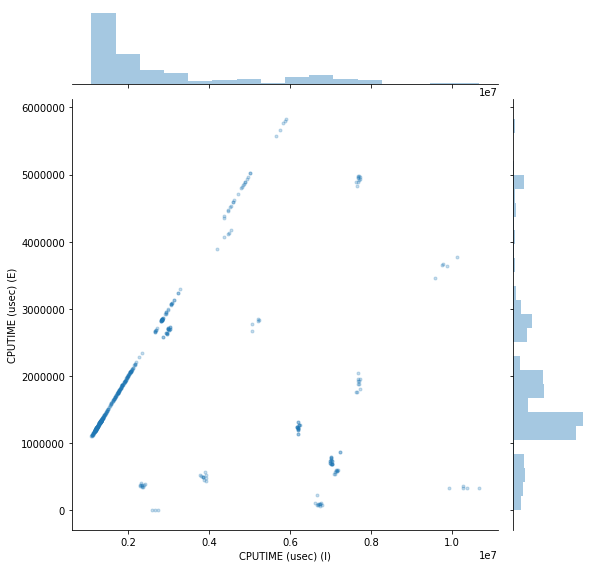

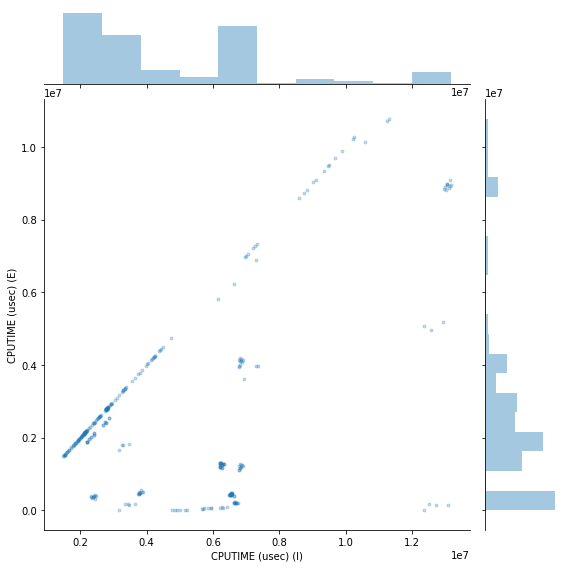

In [54]:
df = fgfs[0].dataframe
df2 = fgfs[1].dataframe
root_max_df = 107348942.00
root_max_df2 = 145114370.00
sns.jointplot('CPUTIME (usec) (I)', 'CPUTIME (usec) (E)',
              df.loc[(df['CPUTIME (usec) (I)'] < 0.10*107348942.00) &
                     (df['CPUTIME (usec) (E)'] > 0)],
              alpha=.25, marker='.', height=8);
sns.jointplot('CPUTIME (usec) (I)', 'CPUTIME (usec) (E)',
              df2.loc[(df2['CPUTIME (usec) (I)'] < 0.10*145114370.00) &
                     (df2['CPUTIME (usec) (E)'] > 0)],
              alpha=.25, marker='.', height=8);

In [69]:
state_gf1.graph = fgfs[0].graph
state_gf1.df = fgfs[0].dataframe

state_gf2.graph = fgfs[1].graph
state_gf2.df = fgfs[1].dataframe
groupBy(fgfs[0], 'path')

AttributeError: 'dict' object has no attribute 'graph'

In [60]:
g1 = nx.DiGraph()
g2 = nx.DiGraph()
def add_paths(g, df, path_name):
    for idx, row in df.iterrows():
        print(row)
        g.add_path(row[path_name])

add_paths(g1, df, 'path')
add_paths(g2, df, 'path')

CPUTIME (usec) (I)           107,348,942.00
CPUTIME (usec) (E)                     0.00
nid                                    2.00
rank                                   0.00
file                         <unknown file>
line                                      0
module                <unknown load module>
name                   <partial call paths>
node                   <partial call paths>
type                                     PF
Name: (<partial call paths>, 0.0), dtype: object


KeyError: 'path'